In [1]:
%matplotlib inline

import ipyvolume as ipv
import math
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import os
import pandas as pd
import skimage.measure
import scipy.interpolate
from scipy.optimize import curve_fit
import trimesh

monoar_colors = [np.array([222,45,38])/255,
                 np.array([252,146,114])/255]
binoar_colors = [np.array([49,130,189])/255,
                 np.array([158,202,225])/255]

In [2]:
# Load the user data
luna_df = pd.read_csv('perceptual_data.csv')
luna_df['nonuniformity'] = (100-luna_df['uniformity'])/(100+luna_df['uniformity'])
luna_df['strongly_worse'] = (luna_df['convresp'] >= 2)
luna_df['any_worse'] = (luna_df['convresp'] >= 1)

In [3]:
# Calculate averages for the different conditions
df = luna_df.groupby(['subject', 'AR', 'luning', 'nonuniformity']).mean().sort_values(by=['nonuniformity']).reset_index()
    
x = {}
y = {}
for criterion in ['strongly_worse', 'any_worse']:
    for AR, luning in (('monoar', 'monolune'),
                       ('binoar', 'binolune')):
        df_subset = df.loc[(df['AR'] == AR) & ((df['luning'] == luning) | (df['luning'] == 'nolune'))]

        x[criterion, AR], y[criterion, AR] = [], []
        for n_idx, n in enumerate(sorted(set(df_subset['nonuniformity']))):
            dat = df_subset[df_subset['nonuniformity']==n][criterion]
            x[criterion, AR].append(n)
            y[criterion, AR].append(dat.mean())

In [4]:
# Gaussian CDF fit, which will be fit to the user data
def cdf_2param(x, mu, sigma):
    return 1/2*(1+math.erf((x-mu)/(sigma*np.sqrt(2))))
cdf_v = np.vectorize(cdf_2param)


# Calculate fits
fits_mean = {}
for crit in ['any_worse', 'strongly_worse']:
    for AR in ('monoar', 'binoar'):
        t = np.linspace(min(x[crit, AR]), max(x[crit, AR]), 1000)
        fit_params = curve_fit(cdf_v, x[crit, AR],
                                      y[crit, AR], p0=[0.5, 2])[0]
        fits_mean[crit, AR] = fit_params

In [5]:
# Calculate the nonuniformity for a given threshold
def f_nonuniformity(P, mu, sigma):
    return np.sqrt(2)*sigma*scipy.special.erfinv(2*P-1)+mu

target_nonuniformity = lambda crit, AR, x, : f_nonuniformity(x, *fits_mean[crit, AR])

In [6]:
# Load the eyepiece nonuniformities
eyepiece_csv = pd.read_csv('eyepiece_nonuniformities_without_eyeroll.csv', header=5)

In [7]:
def rescale_data(eyepiece, data_source=None, scale_data=None):
    if data_source is None:
        data_source = 'nonuniformity'
    if scale_data is None:
        scale_data = 5

    x_orig = eyepiece[['x']].to_numpy().squeeze()
    y_orig = eyepiece[['y']].to_numpy().squeeze()
    z_orig = eyepiece[['z']].to_numpy().squeeze()
    m_orig = eyepiece[[data_source]].to_numpy().squeeze()

    x = np.array(list(sorted(np.unique(x_orig))))
    y = np.array(list(sorted(np.unique(y_orig))))
    z = np.array(list(sorted(np.unique(z_orig))))

    X,Y,Z = np.meshgrid(x, y, z)

    M = scipy.interpolate.griddata((x_orig, y_orig, z_orig), m_orig, (X, Y, Z), method='linear')

    if scale_data:
        M = scipy.ndimage.zoom(M, [scale_data, scale_data, scale_data], output=None, order=3,
                               mode='nearest', prefilter=True)
        x = np.linspace(min(x), max(x), int(len(x)*scale_data))
        y = np.linspace(min(y), max(y), int(len(y)*scale_data))
        z = np.linspace(min(z), max(z), int(len(z)*scale_data))
        
    return [x, y, z, M]

# Calculate the smoothed data
eyepiece_data = rescale_data(eyepiece_csv)
[x, y, z, M] = eyepiece_data.copy()

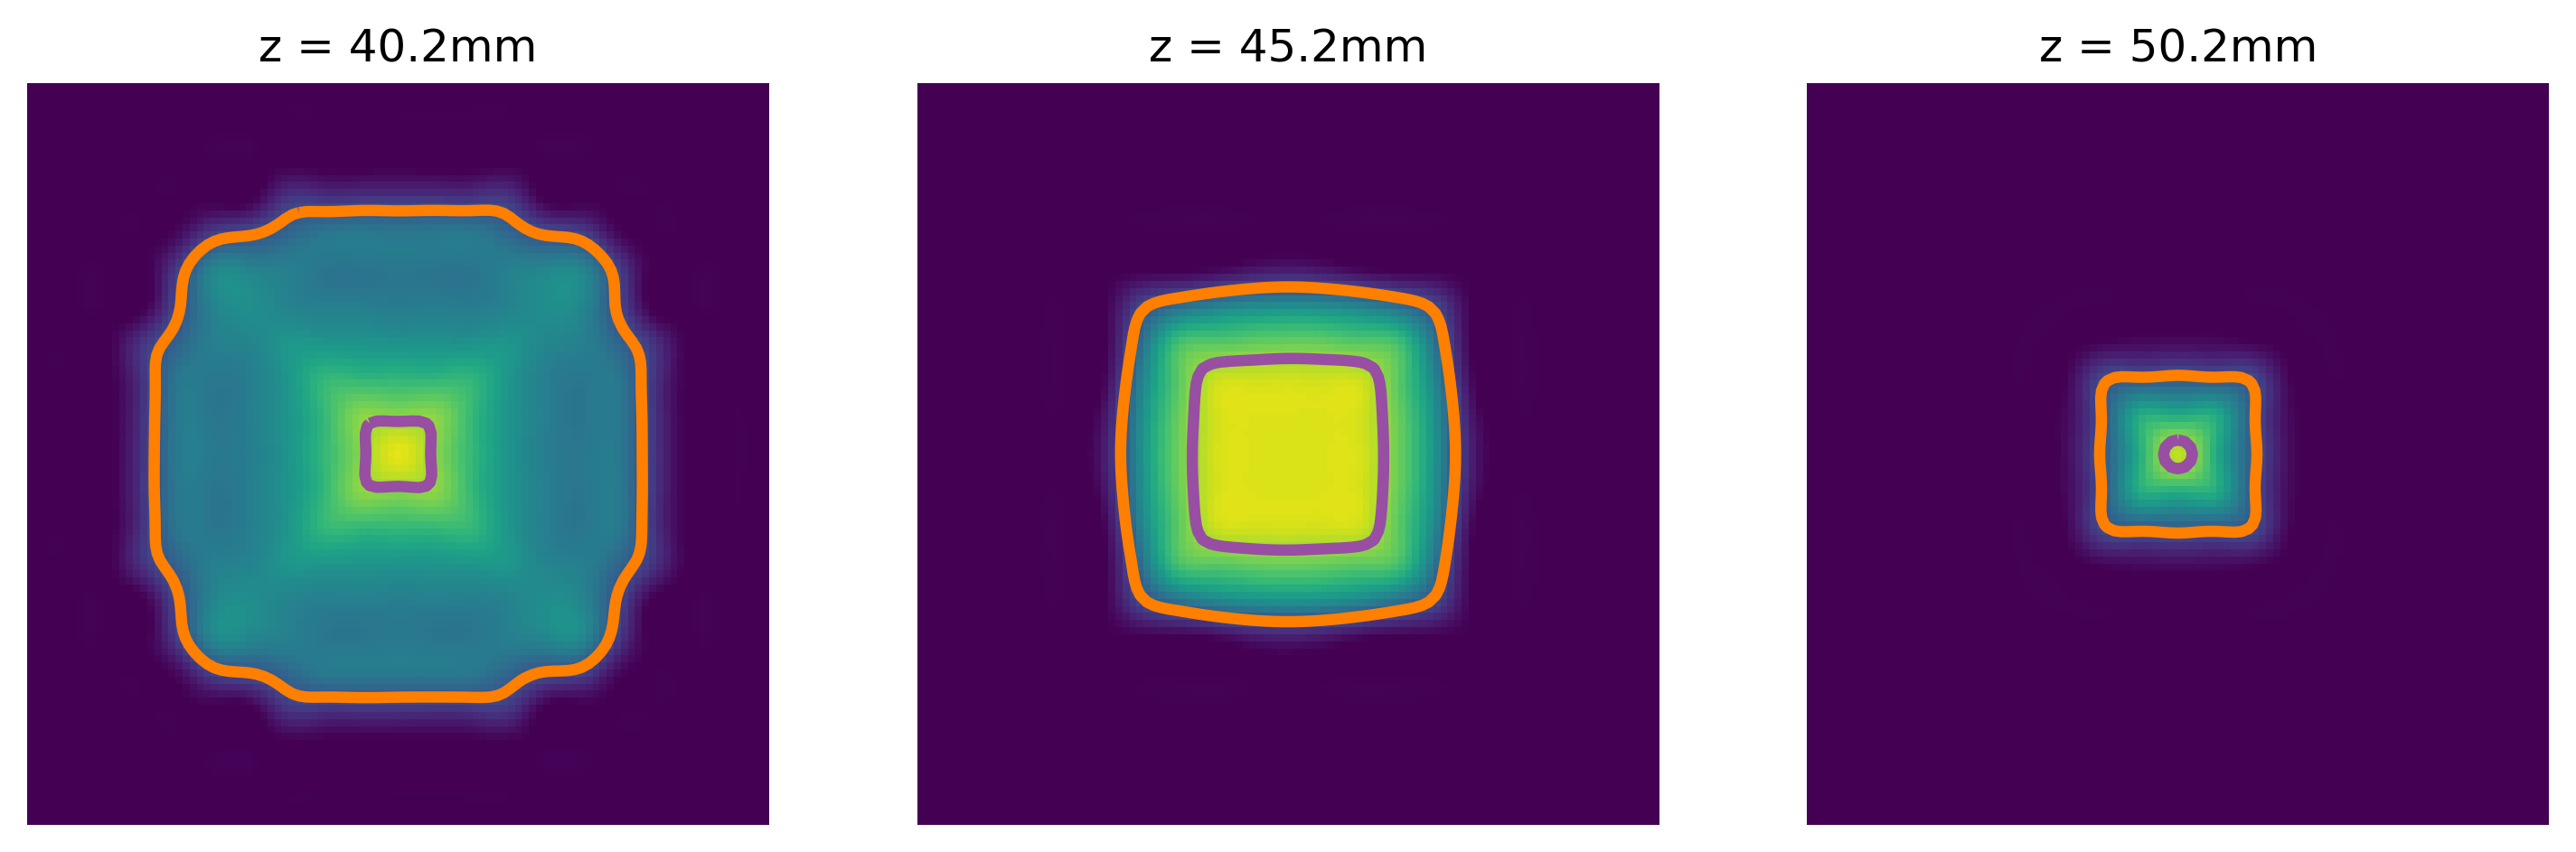

In [8]:
# Figure 4

thresholds = [0.15, 0.75]
colors = [np.array([152,78,163])/255,
          np.array([255,127,0])/255]

f, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
for idx, val in enumerate(np.linspace(min(z), max(z), 5)[1:-1]):
    ax = axs[idx]
    min_value = np.argmin(np.abs(z-val))
    data = M[:,:,min_value]
    img = ax.imshow(data, interpolation='nearest', origin='upper', cmap=plt.get_cmap('viridis_r'), vmin=0, vmax=1)
    ax.contour(data, thresholds, colors=colors, linewidths=3)
    ax.axis('off')
    ax.set_title(f'z = {val:4.1f}mm')
plt.show()

In [9]:
# The following are interactive ipyvolume figures, which need to be run locally to visualize.

In [10]:
# Mono AR, any worse, low criterion
level = target_nonuniformity('any_worse', 'monoar', 0.45)
print(level)
color = monoar_colors[0]

ipv.clear()
fig = ipv.figure(width=768, height=768, )

values = skimage.measure.marching_cubes(M, level)
verts, triangles = values[:2]
mesh = trimesh.Trimesh(vertices=verts, faces=triangles)
print(f'Mesh Volume = {mesh.volume}')

xi, yi, zi = verts.T    
ipv.plot_trisurf(xi, yi, zi, triangles=triangles, color=color, )
ipv.xlim(0, len(x)-1)
ipv.ylim(0, len(y)-1)
ipv.zlim(0, len(z)-1)

ipv.pylab.style.axes_off()
ipv.show()

0.06370590439622312
Mesh Volume = 3036.3743055378022


In [11]:
ipv.view(azimuth=90, elevation=0, distance=1.7)
img_mono_low = ipv.pylab.screenshot()

Output()

In [12]:
# Mono AR, any worse, high criterion
level = target_nonuniformity('any_worse', 'monoar', 0.75)
print(level)
color = monoar_colors[1]

ipv.clear()
fig = ipv.figure(width=768, height=768, )

values = skimage.measure.marching_cubes(M, level)
verts, triangles = values[:2]
mesh = trimesh.Trimesh(vertices=verts, faces=triangles)
print(f'Mesh Volume = {mesh.volume}')

xi, yi, zi = verts.T    
ipv.plot_trisurf(xi, yi, zi, triangles=triangles, color=color, )
ipv.xlim(0, len(x)-1)
ipv.ylim(0, len(y)-1)
ipv.zlim(0, len(z)-1)

ipv.pylab.style.axes_off()
ipv.show()

0.3831483385099913
Mesh Volume = 36321.36272045612


In [13]:
ipv.view(azimuth=90, elevation=0, distance=1.7)
img_mono_high = ipv.pylab.screenshot()

Output()

In [14]:
# Bino AR, any worse, low criterion
level = target_nonuniformity('any_worse', 'binoar', 0.45)
print(level)
color = binoar_colors[0]

ipv.clear()
fig = ipv.figure(width=768, height=768, )

values = skimage.measure.marching_cubes(M, level)
verts, triangles = values[:2]
mesh = trimesh.Trimesh(vertices=verts, faces=triangles)
print(f'Mesh Volume = {mesh.volume}')

xi, yi, zi = verts.T    
ipv.plot_trisurf(xi, yi, zi, triangles=triangles, color=color, )
ipv.xlim(0, len(x)-1)
ipv.ylim(0, len(y)-1)
ipv.zlim(0, len(z)-1)

ipv.pylab.style.axes_off()
ipv.show()

0.1637175026178089
Mesh Volume = 12524.065107934148


In [15]:
ipv.view(azimuth=90, elevation=0, distance=1.7)
img_bino_low = ipv.pylab.screenshot()

Output()

In [16]:
# Bino AR, any worse, high criterion
level = target_nonuniformity('any_worse', 'binoar', 0.75)
print(level)
color = binoar_colors[1]

ipv.clear()
fig = ipv.figure(width=768, height=768, )

values = skimage.measure.marching_cubes(M, level)
verts, triangles = values[:2]
mesh = trimesh.Trimesh(vertices=verts, faces=triangles)
print(f'Mesh Volume = {mesh.volume}')

xi, yi, zi = verts.T    
ipv.plot_trisurf(xi, yi, zi, triangles=triangles, color=color, )
ipv.xlim(0, len(x)-1)
ipv.ylim(0, len(y)-1)
ipv.zlim(0, len(z)-1)

ipv.pylab.style.axes_off()
ipv.show()

0.6721483859744444
Mesh Volume = 77683.55307139152


In [17]:
ipv.view(azimuth=90, elevation=0, distance=1.7)
img_bino_high = ipv.pylab.screenshot()

Output()

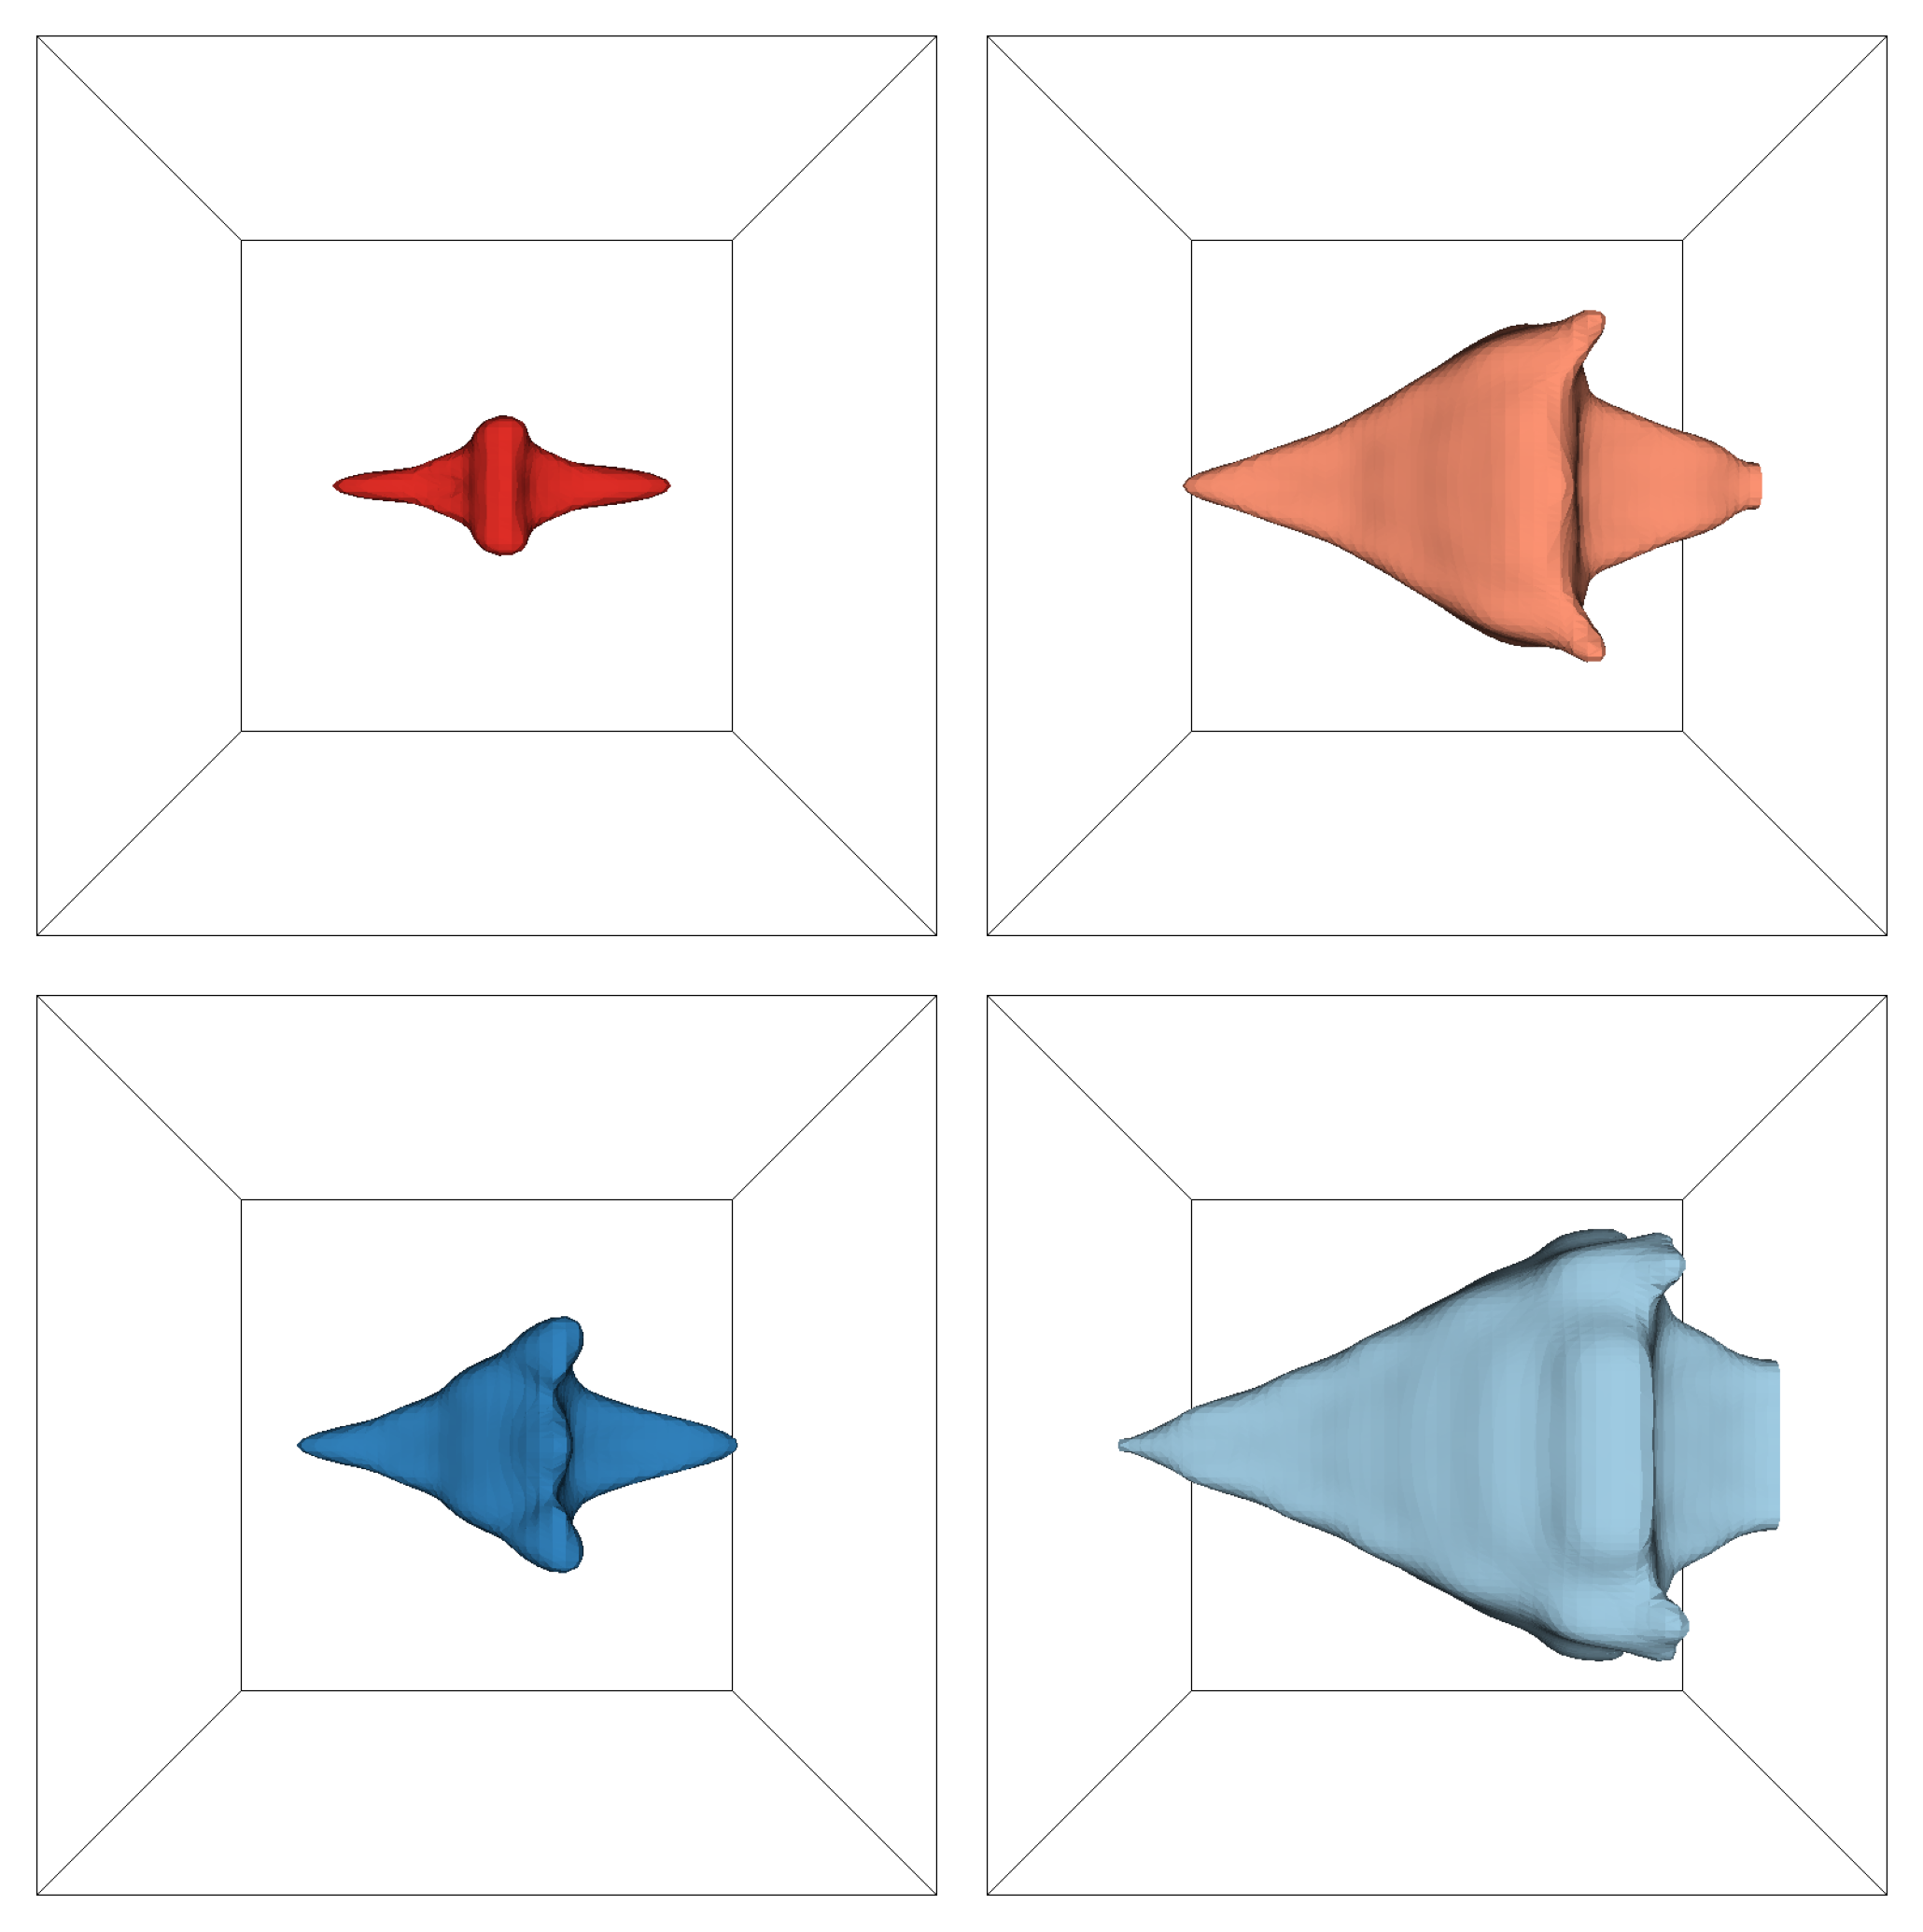

In [18]:
f, ax = plt.subplots(2, 2, figsize=(7, 7), dpi=300)
ax[0, 0].imshow(img_mono_low)
ax[0, 1].imshow(img_mono_high)
ax[1, 0].imshow(img_bino_low)
ax[1, 1].imshow(img_bino_high)
for a in ax.flatten():
    a.axis('off')

plt.tight_layout()
plt.show()